# Use PyTorch to recognize hand-written digits with Watson Machine Learning REST API

This notebook contains steps and code to demonstrate support of PyTorch Deep Learning experiments in Watson Machine Learning Service. It introduces commands for getting data, training experiments, persisting pipelines, publishing models, deploying models and scoring.

Some familiarity with cURL is helpful. This notebook uses cURL examples.


## Learning goals

The learning goals of this notebook are:

-  Working with Watson Machine Learning experiments to train Deep Learning models.
-  Downloading computed models to local storage.
-  Online deployment and scoring of trained model.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)   
2.  [Model definition](#model_definition)  
3.	[Experiment Run](#run)  
4.	[Historical runs](#runs)  
5.	[Deploy and Score](#deploy_and_score)  
6.	[Cleaning](#cleaning)   
7.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Contact with your Cloud Pack for Data administrator and ask him for your account credentials

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud Pack for Data. You need to provide platform `url`, your `username` and `api_key`.

In [ ]:
%env USERNAME=
%env API_KEY=
%env RUNTIME_ENV_APSX_URL=

%env SPACE_ID=

<a id="wml_token"></a>
### Getting WML authorization token for further cURL calls

<a href="https://cloud.ibm.com/docs/cloud-object-storage?topic=cloud-object-storage-curl#curl-token" target="_blank" rel="noopener no referrer">Example of cURL call to get WML token</a>

<a id="space_creation"></a>
### Space creation
**Tip:** If you do not have `space` already created, please convert below three cells to `code` and run them.

First of all, you need to create a `space` that will be used in all of your further cURL calls. 
If you do not have `space` already created, below is the cURL call to create one.

<a href="https://cpd-spaces-api.eu-gb.cf.appdomain.cloud/#/Spaces/spaces_create" 
target="_blank" rel="noopener no referrer">Space creation</a>

<a href="https://cpd-spaces-api.eu-gb.cf.appdomain.cloud/#/Spaces/spaces_get" 
target="_blank" rel="noopener no referrer">Get space information</a>

In [33]:
%env SPACE_ID=ddd3bbfc-1ab8-4e6b-ac97-0dc60764ad51

env: SPACE_ID=ddd3bbfc-1ab8-4e6b-ac97-0dc60764ad51


In [38]:
%%bash

curl -sk -X GET \
    --header "Authorization: Bearer $USER_ACCESS_TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    "$RUNTIME_ENV_APSX_URL/v2/spaces/$SPACE_ID"

{
  "entity": {
    "compute": [{
      "crn": "crn:v1:cpd:private:pm-20:private:a/cpduser:99999999-9999-9999-9999-999999999999::",
      "guid": "99999999-9999-9999-9999-999999999999",
      "name": "Watson Machine Learning",
      "type": "machine_learning"
    }],
    "name": "MSK Test Space Wendy",
    "scope": {
      "bss_account_id": "cpdaccount"
    },
    "status": {
      "state": "active"
    }
  },
  "metadata": {
    "created_at": "2021-12-03T04:23:07.704Z",
    "creator_id": "1000331002",
    "id": "ddd3bbfc-1ab8-4e6b-ac97-0dc60764ad51",
    "updated_at": "2021-12-03T04:23:14.447Z",
    "url": "/v2/spaces/ddd3bbfc-1ab8-4e6b-ac97-0dc60764ad51"
  }
}

<a id="model_definition"></a>
## 2. Model definition 

This section provides samples about how to store model definition via cURL calls.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Model%20Definitions/model_definitions_create" 
target="_blank" rel="noopener no referrer">Store a model definition for Deep Learning experiment</a>

In [41]:
%%bash --out model_definition_payload

MODEL_DEFINITION_PAYLOAD='{"name": "PyTorch Hand-written Digit Recognition", "space_id": "'"$SPACE_ID"'", "description": "PyTorch Hand-written Digit Recognition", "tags": ["DL", "PyTorch"], "version": "v1", "platform": {"name": "python", "versions": ["3.8"]}, "command": "pytorch_v_1.1_mnist_onnx.py --epochs 10 --debug-level debug"}'
echo $MODEL_DEFINITION_PAYLOAD | python -m json.tool

In [42]:
%env MODEL_DEFINITION_PAYLOAD=$model_definition_payload

env: MODEL_DEFINITION_PAYLOAD={
    "name": "PyTorch Hand-written Digit Recognition",
    "space_id": "ddd3bbfc-1ab8-4e6b-ac97-0dc60764ad51",
    "description": "PyTorch Hand-written Digit Recognition",
    "tags": [
        "DL",
        "PyTorch"
    ],
    "version": "v1",
    "platform": {
        "name": "python",
        "versions": [
            "3.8"
        ]
    },
    "command": "pytorch_v_1.1_mnist_onnx.py --epochs 10 --debug-level debug"
}


In [43]:
!echo $MODEL_DEFINITION_PAYLOAD

{ "name": "PyTorch Hand-written Digit Recognition", "space_id": "ddd3bbfc-1ab8-4e6b-ac97-0dc60764ad51", "description": "PyTorch Hand-written Digit Recognition", "tags": [ "DL", "PyTorch" ], "version": "v1", "platform": { "name": "python", "versions": [ "3.8" ] }, "command": "pytorch_v_1.1_mnist_onnx.py --epochs 10 --debug-level debug" }


In [51]:
%%bash --out model_definition_id

curl -sk -X POST \
    --header "Authorization: Bearer $USER_ACCESS_TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    --data "$MODEL_DEFINITION_PAYLOAD" \
    "$RUNTIME_ENV_APSX_URL/ml/v4/model_definitions?version=2021-05-01"| grep '"id": ' | awk -F '"' '{ print $4 }'

In [50]:
!curl -k -X POST \
    --header "Authorization: Bearer $USER_ACCESS_TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    --data "$MODEL_DEFINITION_PAYLOAD" \
    "$RUNTIME_ENV_APSX_URL/ml/v4/model_definitions?version=2021-05-01"

{
  "entity": {
    "command": "pytorch_v_1.1_mnist_onnx.py --epochs 10 --debug-level debug",
    "platform": {
      "name": "python",
      "versions": ["3.8"]
    },
    "version": "v1"
  },
  "metadata": {
    "created_at": "2021-12-04T16:45:30.700Z",
    "description": "PyTorch Hand-written Digit Recognition",
    "id": "1793abdb-06e3-47c5-84f5-337cd66810f9",
    "modified_at": "2021-12-04T16:45:30.700Z",
    "name": "PyTorch Hand-written Digit Recognition",
    "owner": "1000331002",
    "space_id": "ddd3bbfc-1ab8-4e6b-ac97-0dc60764ad51",
    "tags": ["DL", "PyTorch"]
  },
  "system": {
    "warnings": []
  }
}

In [52]:
%env MODEL_DEFINITION_ID=$model_definition_id

env: MODEL_DEFINITION_ID=73ba95f9-7c8c-451a-9034-3466f3dc202c


<a id="model_preparation"></a>
### Model preparation

Download files with pytorch code. You can either download it via link below or run the cell below the link.

<a href="https://github.com/IBM/watson-machine-learning-samples/raw/master/cpd4.0/definitions/pytorch/mnist/pytorch-onnx_v1_3.zip" 
target="_blank" rel="noopener no referrer">Download pytorch-model.zip</a>

In [9]:
%%bash

wget https://github.com/IBM/watson-machine-learning-samples/raw/master/cpd4.0/definitions/pytorch/mnist/pytorch_onnx_v1_3.zip \
     -O pytorch-onnx_v1_3.zip

--2021-12-04 03:03:27--  https://github.com/IBM/watson-machine-learning-samples/raw/master/cpd4.0/definitions/pytorch/mnist/pytorch_onnx_v1_3.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cpd4.0/definitions/pytorch/mnist/pytorch_onnx_v1_3.zip [following]
--2021-12-04 03:03:27--  https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cpd4.0/definitions/pytorch/mnist/pytorch_onnx_v1_3.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4061 (4.0K) [application/zip]
Saving to: ‘pytorch-onnx_v1_3.zip’

     0K ...                

**Tip**: Convert below cell to code and run it to see model deinition's code.

In [53]:
!unzip -oqd . pytorch-onnx_v1_3.zip && cat pytorch_v_1.1_mnist_onnx.py

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
from emetrics import EMetrics
import torch.onnx


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
       

<a id="def_upload"></a>
### Upload model for the model definition

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Model%20Definitions/model_definitions_upload_model" 
target="_blank" rel="noopener no referrer">Upload model for the model definition</a>

In [54]:
%%bash

curl -sk -X PUT \
    --header "Authorization: Bearer $USER_ACCESS_TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    --data-binary "@pytorch-onnx_v1_3.zip" \
    "$RUNTIME_ENV_APSX_URL/ml/v4/model_definitions/$MODEL_DEFINITION_ID/model?version=2021-05-01&space_id=$SPACE_ID" \
    | python -m json.tool

{
    "attachment_id": "e1b327ca-b73b-48ac-8397-d6ecfed4d9e6",
    "content_format": "native",
    "persisted": true
}


<a id="run"></a>
## 3. Experiment run

This section provides samples about how to trigger Deep Learning experiment via cURL calls.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Trainings/trainings_create" 
target="_blank" rel="noopener no referrer">Schedule a training job for Deep Learning experiment</a>

Specify the source files folder where you have stored your training data. The path should point to a local repository on Watson Machine Learning Accelerator that your system administrator has set up for your use.

**Store your training data in WML-A's storage.** One way to do this is:
1. go to WML-A's notebook server
2. download/upload the training data to /data/ folder, for example `/data/MNIST/`
3. come back here and supply 'MNIST' as the relative path for training data

**Action:**
Change `training_data_references: location: path: ...`

In [67]:
%%bash --out training_payload

TRAINING_PAYLOAD='{"training_data_references": [{"name": "training_input_data", "type": "fs", "connection": {}, "location": {"path": "MNIST"}, "schema": {"id": "idmlp_schema", "fields": [{"name": "text", "type": "string"}]}}], "results_reference": {"name": "MNIST results", "connection": {}, "location": {"path": "spaces/'"$SPACE_ID"'/assets/experiment"}, "type": "fs"}, "tags": [{"value": "tags_pytorch", "description": "Tags PyTorch"}], "name": "PyTorch hand-written Digit Recognition", "description": "PyTorch hand-written Digit Recognition", "model_definition": {"id": "'"$MODEL_DEFINITION_ID"'", "command": "pytorch_v_1.1_mnist_onnx.py --epochs 10 --debug-level debug", "hardware_spec": {"name": "K80", "nodes": 1}, "software_spec": {"name": "pytorch-onnx_1.7-py3.8"}, "parameters": {"name": "PyTorch_mnist", "description": "PyTorch mnist recognition"}}, "space_id": "'"$SPACE_ID"'"}'
echo $TRAINING_PAYLOAD | python -m json.tool

In [68]:
%env TRAINING_PAYLOAD=$training_payload

env: TRAINING_PAYLOAD={
    "training_data_references": [
        {
            "name": "training_input_data",
            "type": "fs",
            "connection": {},
            "location": {
                "path": "MNIST"
            },
            "schema": {
                "id": "idmlp_schema",
                "fields": [
                    {
                        "name": "text",
                        "type": "string"
                    }
                ]
            }
        }
    ],
    "results_reference": {
        "name": "MNIST results",
        "connection": {},
        "location": {
            "path": "spaces/ddd3bbfc-1ab8-4e6b-ac97-0dc60764ad51/assets/experiment"
        },
        "type": "fs"
    },
    "tags": [
        {
            "value": "tags_pytorch",
            "description": "Tags PyTorch"
        }
    ],
    "name": "PyTorch hand-written Digit Recognition",
    "description": "PyTorch hand-written Digit Recognition",
    "model_definition": {
    

In [69]:
%%bash --out training_id

curl -sk -X  POST \
    --header "Authorization: Bearer $USER_ACCESS_TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    --data "$TRAINING_PAYLOAD" \
    "$RUNTIME_ENV_APSX_URL/ml/v4/trainings?version=2021-05-01" | awk -F'"id":' '{print $2}' | cut -c2-37

In [70]:
%env TRAINING_ID=$training_id

env: TRAINING_ID=ceae0c10-bf5b-4606-9e76-bd9bb3480040


<a id="training_details"></a>
### Get training details
Treining is an asynchronous endpoint. In case you want to monitor training status and details,
you need to use a GET method and specify which training you want to monitor by usage of training ID.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Trainings/trainings_get" 
target="_blank" rel="noopener no referrer">Get information about training job</a>

### Get training status

In [77]:
%%bash

STATUS=$(curl -sk -X GET\
    --header "Authorization: Bearer $USER_ACCESS_TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    "$RUNTIME_ENV_APSX_URL/ml/v4/trainings/$TRAINING_ID?space_id=$SPACE_ID&version=2021-05-01")
    
STATUS=${STATUS#*state\":\"}
STATUS=${STATUS%%\"*}
echo $STATUS

completed


Please make sure that training is completed before you go to the next sections.
Monitor `state` of your training by running above cell couple of times.

<a id="runs"></a>
## 4. Historical runs

In this section you will see cURL examples describing how to get historical training runs information.

Output should be similar to the output from training creation but you should see more trainings entries.  
Listing trainings:

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Trainings/trainings_list" 
target="_blank" rel="noopener no referrer">Get list of historical training jobs information</a>

In [79]:
%%bash

HISTORICAL_TRAINING_LIMIT_TO_GET=1

curl -sk -X GET \
    --header "Authorization: Bearer $USER_ACCESS_TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    "$RUNTIME_ENV_APSX_URL/ml/v4/trainings?space_id=$SPACE_ID&version=2021-05-01&limit=$HISTORICAL_TRAINING_LIMIT_TO_GET" \
    | python -m json.tool

{
    "limit": 1,
    "next": {
        "href": "/ml/v4/trainings?start=g1AAAACbeJw1zDEOwjAMheGoExMzB2A1shvHaXoOJhYUx6mgFCFBF24PQWJ9-r-3OOe6S2du-1rzc73V99ke5Wr3774vNVcshKBTUGBBgVSjgFpS9TwgMja7-dulvf2omXnVqQBlHYCrKOSSIqAVwSicLVALdz32BNQD8pFkDDKyP7CX0zx_AGUYJ1Y&limit=1&space_id=ddd3bbfc-1ab8-4e6b-ac97-0dc60764ad51"
    },
    "resources": [
        {
            "metadata": {
                "created_at": "2021-12-04T16:53:09.220Z",
                "description": "PyTorch hand-written Digit Recognition",
                "guid": "ceae0c10-bf5b-4606-9e76-bd9bb3480040",
                "id": "ceae0c10-bf5b-4606-9e76-bd9bb3480040",
                "modified_at": "2021-12-04T16:56:43.436Z",
                "name": "PyTorch hand-written Digit Recognition",
                "space_id": "ddd3bbfc-1ab8-4e6b-ac97-0dc60764ad51",
                "tags": [
                    "tags_pytorch"
                ]
            },
            "entity": {
                "description": "PyTorch hand-written Di

<a id="training_cancel"></a>
### Cancel training run

**Tip:** If you want to cancel your training, please convert below cell to `code`, specify training ID and run.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Trainings/trainings_delete" 
target="_blank" rel="noopener no referrer">Canceling training</a>

---

<a id="deploy_and_score"></a>
## 5. Deploy and Score

In this section you will learn how to deploy and score pipeline model as webservice using WML instance.

Before deployment creation, you need store your model in WML repository.
Please see below cURL call example how to do it.

Download `request.json` with repository request json for model storing.

In [80]:
%%bash --out request_json

curl -sk -X GET \
    --header "Authorization: Bearer $USER_ACCESS_TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    "$RUNTIME_ENV_APSX_URL/v2/asset_files/experiment/$TRAINING_ID/assets/$TRAINING_ID/resources/wml_model/request.json?space_id=$SPACE_ID&version=2020-08-01" \
    | python -m json.tool

In [81]:
%env MODEL_PAYLOAD=$request_json

env: MODEL_PAYLOAD={
    "model_definition": {
        "id": "73ba95f9-7c8c-451a-9034-3466f3dc202c"
    },
    "name": "model_wmla-ns-35",
    "content_location": {
        "connection": {},
        "contents": [
            {
                "content_format": "native",
                "file_name": "wmla-ns-35.zip",
                "location": "spaces/ddd3bbfc-1ab8-4e6b-ac97-0dc60764ad51/assets/experiment/ceae0c10-bf5b-4606-9e76-bd9bb3480040/assets/ceae0c10-bf5b-4606-9e76-bd9bb3480040/resources/wml_model/wmla-ns-35.zip"
            }
        ],
        "location": {
            "path": "spaces/ddd3bbfc-1ab8-4e6b-ac97-0dc60764ad51/assets/experiment",
            "model": "spaces/ddd3bbfc-1ab8-4e6b-ac97-0dc60764ad51/assets/experiment/ceae0c10-bf5b-4606-9e76-bd9bb3480040/data/model",
            "notebooks_path": "spaces/ddd3bbfc-1ab8-4e6b-ac97-0dc60764ad51/assets/experiment/ceae0c10-bf5b-4606-9e76-bd9bb3480040/notebooks",
            "training": "spaces/ddd3bbfc-1ab8-4e6b-ac97-0dc60764ad

<a id="model_store"></a>
### Store Deep Learning model

Store information about your model to WML repository.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Models/models_create" 
target="_blank" rel="noopener no referrer">Model storing</a>

In [23]:
%%bash --out model_details

curl -sk -X POST \
    --header "Authorization: Bearer $USER_ACCESS_TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    --data "$MODEL_PAYLOAD" \
    "$RUNTIME_ENV_APSX_URL/ml/v4/models?version=2020-08-01&space_id=$SPACE_ID"

In [24]:
%env MODEL_DETAILS=$model_details

env: MODEL_DETAILS={
  "entity": {
    "content_import_state": "running",
    "model_definition": {
      "id": "ecea5add-e901-4416-9592-18bcfcf84557"
    },
    "software_spec": {
      "id": "8d5d8a87-a912-54cf-81ec-3914adaa988d",
      "name": "pytorch-onnx_1.3-py3.7"
    },
    "training_data_references": [{
      "connection": {

      },
      "location": {
        "path": "pytorch-mnist"
      },
      "schema": {
        "fields": [{
          "name": "text",
          "type": "string"
        }],
        "id": "idmlp_schema"
      },
      "type": "fs"
    }],
    "type": "pytorch-onnx_1.3"
  },
  "metadata": {
    "created_at": "2020-12-10T14:08:18.803Z",
    "id": "a3c15f28-ffe2-4e5a-b7bb-92898150738d",
    "modified_at": "2020-12-10T14:08:18.803Z",
    "name": "model_twmla-2694",
    "owner": "1000331009",
    "space_id": "dfabc53a-c862-4a4c-9161-e74d6726629a"
  },
  "system": {
    "warnings": []
  }
}


In [25]:
%%bash --out model_id

echo $MODEL_DETAILS | awk -F '"id": ' '{ print $5 }' | cut -d '"' -f 2

In [26]:
%env MODEL_ID=$model_id

env: MODEL_ID=a3c15f28-ffe2-4e5a-b7bb-92898150738d


<a id="deployment_creation"></a>
### Deployment creation

An Deep Learning online deployment creation is presented below.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Deployments/deployments_create" 
target="_blank" rel="noopener no referrer">Create deployment</a>

In [27]:
%%bash --out deployment_payload

DEPLOYMENT_PAYLOAD='{"space_id": "'"$SPACE_ID"'","name": "PyTorch Mnist deployment", "description": "PyTorch model to recognize hand-written digits","online": {},"hardware_spec": {"name": "S"},"asset": {"id": "'"$MODEL_ID"'"}}'
echo $DEPLOYMENT_PAYLOAD | python -m json.tool

In [28]:
%env DEPLOYMENT_PAYLOAD=$deployment_payload

env: DEPLOYMENT_PAYLOAD={
    "space_id": "dfabc53a-c862-4a4c-9161-e74d6726629a",
    "name": "PyTorch Mnist deployment",
    "description": "PyTorch model to recognize hand-written digits",
    "online": {},
    "hardware_spec": {
        "name": "S"
    },
    "asset": {
        "id": "a3c15f28-ffe2-4e5a-b7bb-92898150738d"
    }
}


In [29]:
%%bash

curl -sk -X POST \
    --header "Authorization: Bearer $USER_ACCESS_TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    --data "$DEPLOYMENT_PAYLOAD" \
    "$RUNTIME_ENV_APSX_URL/ml/v4/deployments?version=2020-08-01"

{
  "entity": {
    "asset": {
      "id": "a3c15f28-ffe2-4e5a-b7bb-92898150738d"
    },
    "custom": {

    },
    "deployed_asset_type": "model",
    "description": "PyTorch model to recognize hand-written digits",
    "hardware_spec": {
      "id": "e7ed1d6c-2e89-42d7-aed5-863b972c1d2b",
      "name": "S",
      "num_nodes": 1
    },
    "name": "PyTorch Mnist deployment",
    "online": {

    },
    "space_id": "dfabc53a-c862-4a4c-9161-e74d6726629a",
    "status": {
      "online_url": {
        "url": "https://wmlgm-cpd-wmlgm.apps.wml1x180.ma.platformlab.ibm.com/ml/v4/deployments/e5133928-182a-436d-b544-4e15f17ebba6/predictions"
      },
      "state": "initializing"
    }
  },
  "metadata": {
    "created_at": "2020-12-10T14:08:20.222Z",
    "description": "PyTorch model to recognize hand-written digits",
    "id": "e5133928-182a-436d-b544-4e15f17ebba6",
    "modified_at": "2020-12-10T14:08:20.222Z",
    "name": "PyTorch Mnist deployment",
    "owner": "1000331009",
    "space_i

In [30]:
%%bash --out deployment_id

curl -sk -X POST \
    --header "Authorization: Bearer $USER_ACCESS_TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    --data "$DEPLOYMENT_PAYLOAD" \
    "$RUNTIME_ENV_APSX_URL/ml/v4/deployments?version=2020-08-01" \
    | grep '"id": ' | awk -F '"' '{ print $4 }' | sed -n 3p

In [31]:
%env DEPLOYMENT_ID=$deployment_id

env: DEPLOYMENT_ID=c772c05f-a2ff-4618-87f5-c8f6dbc26726


<a id="deployment_details"></a>
### Get deployment details
As deployment API is asynchronous, please make sure your deployment is in `ready` state before going to the next points.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Deployments/deployments_get" 
target="_blank" rel="noopener no referrer">Get deployment details</a>

In [32]:
%%bash

curl -sk -X GET \
    --header "Authorization: Bearer $USER_ACCESS_TOKEN" \
    --header "Content-Type: application/json" \
    "$RUNTIME_ENV_APSX_URL/ml/v4/deployments/$DEPLOYMENT_ID?space_id=$SPACE_ID&version=2020-08-01" \
    | python -m json.tool

{
    "entity": {
        "asset": {
            "id": "a3c15f28-ffe2-4e5a-b7bb-92898150738d"
        },
        "custom": {},
        "deployed_asset_type": "model",
        "description": "PyTorch model to recognize hand-written digits",
        "hardware_spec": {
            "id": "Not_Applicable",
            "name": "S",
            "num_nodes": 1
        },
        "name": "PyTorch Mnist deployment",
        "online": {},
        "space_id": "dfabc53a-c862-4a4c-9161-e74d6726629a",
        "status": {
            "online_url": {
                "url": "https://wmlgm-cpd-wmlgm.apps.wml1x180.ma.platformlab.ibm.com/ml/v4/deployments/c772c05f-a2ff-4618-87f5-c8f6dbc26726/predictions"
            },
            "state": "ready"
        }
    },
    "metadata": {
        "created_at": "2020-12-10T14:08:22.766Z",
        "description": "PyTorch model to recognize hand-written digits",
        "id": "c772c05f-a2ff-4618-87f5-c8f6dbc26726",
        "modified_at": "2020-12-10T14:08:22.766Z",


<a id="input_score"></a>
### Prepare scoring input data
**Hint:** You may need to install numpy using following command `!pip install numpy`

In [33]:
!wget -q https://github.com/IBM/watson-machine-learning-samples/raw/master/cpd4.0/data/mnist/mnist.npz

In [34]:
import numpy as np

mnist_dataset = np.load('mnist.npz')
test_mnist = mnist_dataset['x_test']

In [35]:
image_1 = [test_mnist[0].tolist()]
image_2 = [test_mnist[1].tolist()]

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

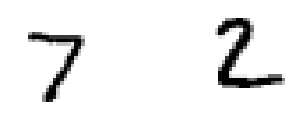

In [37]:
for i, image in enumerate([test_mnist[0], test_mnist[1]]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

<a id="webservice_score"></a>
### Scoring of a webservice
If you want to make a `score` call on your deployment, please follow a below method:

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Deployment%20Jobs/deployment_jobs_create" 
target="_blank" rel="noopener no referrer">Create deployment job</a>

In [38]:
%%bash -s "$image_1" "$image_2"

curl -sk -X POST \
    --header "Authorization: Bearer $USER_ACCESS_TOKEN" \
    --header "Content-Type: application/json" \
    --header "Accept: application/json" \
    --data '{"space_id": "$SPACE_ID","input_data": [{"values": ['"$1"', '"$2"']}]}' \
    "$RUNTIME_ENV_APSX_URL/ml/v4/deployments/$DEPLOYMENT_ID/predictions?version=2020-08-01" \
    | python -m json.tool

{
    "predictions": [
        {
            "values": [
                [
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                    1.0,
                    0.0,
                    0.0
                ],
                [
                    0.0,
                    0.0,
                    1.0,
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                    0.0
                ]
            ]
        }
    ]
}


<a id="deployments_list"></a>
### Listing all deployments

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Deployments/deployments_list" 
target="_blank" rel="noopener no referrer">List deployments details</a>

In [32]:
%%bash

curl -sk -X GET \
    --header "Authorization: Bearer $USER_ACCESS_TOKEN" \
    --header "Content-Type: application/json" \
    "$RUNTIME_ENV_APSX_URL/ml/v4/deployments?space_id=$SPACE_ID&version=2020-08-01" \
    | python -m json.tool

{
    "resources": []
}


<a id="cleaning"></a>
## 6. Cleaning section

Below section is useful when you want to clean all of your previous work within this notebook.
Just convert below cells into the `code` and run them.

<a id="training_delete"></a>
### Delete training run
**Tip:** You can completely delete a training run with its metadata.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Trainings/trainings_delete" 
target="_blank" rel="noopener no referrer">Deleting training</a>

<a id="deployment_delete"></a>
### Deleting deployment
**Tip:** You can delete existing deployment by calling DELETE method.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Deployments/deployments_delete" 
target="_blank" rel="noopener no referrer">Delete deployment</a>

<a id="model_delete"></a>
### Delete model from repository
**Tip:** If you want to completely remove your stored model and model metadata, just use a DELETE method.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Models/models_delete" 
target="_blank" rel="noopener no referrer">Delete model from repository</a>

<a id="def_delete"></a>
### Delete model definition
**Tip:** If you want to completely remove your model definition, just use a DELETE method.

<a href="https://watson-ml-v4-api.mybluemix.net/wml-restapi-cloud.html#/Model%20Definitions/model_definitions_delete" 
target="_blank" rel="noopener no referrer">Delete model definition</a>

<a id="summary"></a>
## 7. Summary and next steps

 You successfully completed this notebook!.
 
 You learned how to use `cURL` calls to store, deploy and score a PyTorch Deep Learning model in WML. 

### Authors

**Jan Sołtysik**, Intern in Watson Machine Learning at IBM

Copyright © 2020, 2021 IBM. This notebook and its source code are released under the terms of the MIT License.